# TLACAMR Analyses: Tables and plots

Here we showcase the results of our evaluations.

* ChEMBL234 - Highest amount of molecules in dataset.
* ChEMBL2835 - Lowest amount of molecules in dataset
* ChEMBL4616 - Highest amount of mean cliff partners
* ChEMBL4203 - Lowest amount of mean cliff partners
* ChEMBL2047 - Highest SMILEs similarity
* ChEMBL264 - Highest mean scaffold similarity
* ChEMBL4792 - Highest mean substructure similarity

## Setup

### Colab mount

In [1]:
import os.path

try:
    from google.colab import drive
    drive.mount('/content/drive')
    _home = 'drive/MyDrive/tlacamr'
except ImportError:
    _home = '~'
finally:
    project_root = os.path.join(_home, 'tlacamr')

print(project_root)

plot_dir = os.path.join(project_root, 'data', 'plot')

Mounted at /content/drive
drive/MyDrive/tlacamr/tlacamr



### Imports

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
mlp_results_data = pd.read_csv(os.path.join(plot_dir, 'mlp_results.csv'))
mlp_results_data.head()

,Model,Dataset,Task,Metric,Value
0,MLP_2048,CHEMBL234_Ki,classification,AUROC,0.807120
1,MLP_2048,CHEMBL234_Ki,regression,RMSE,1.518587
2,MLP_2048,CHEMBL234_Ki,regression,Cliff_RMSE,1.400504
3,MLP_2048,CHEMBL2835_Ki,classification,AUROC,0.925119
4,MLP_2048,CHEMBL2835_Ki,regression,RMSE,1.211433


In [4]:
ac_results_data = pd.read_csv(os.path.join(plot_dir, 'ac_results.csv'))
ac_results_data.head()

,Model,Dataset,Task,Metric,Value
0,pt_joint_1024,CHEMBL234_Ki,classification,AUROC,0.799924
1,pt_joint_1024,CHEMBL234_Ki,regression,RMSE,1.492226
2,pt_joint_1024,CHEMBL234_Ki,regression,Cliff_RMSE,1.363969
3,pt_joint_1024,CHEMBL2835_Ki,classification,AUROC,0.843431
4,pt_joint_1024,CHEMBL2835_Ki,regression,RMSE,1.241787


In [6]:
# Define the dataset renaming map
dataset_descriptions = {
    'CHEMBL234_Ki': 'Max Mol', #'Most Molecules',
    'CHEMBL2835_Ki': 'Min Mol', #'Fewest Molecules',
    'CHEMBL4616_EC50': 'Max AC', #'Most Cliff Partners',
    'CHEMBL4203_Ki': 'Min AC', #'Fewest Cliff Partners',
    'CHEMBL2047_EC50': 'SMILES', #'Highest SMILES Similarity',
    'CHEMBL264_Ki':  'Scaffold', #'Highest Scaffold Similarity',
    'CHEMBL4792_Ki': 'Sub', #'Highest Substructure Similarity'
}

mlp_names = {
    'MLP_256': 'MLP 256',
    'MLP_1024': 'MLP 1024',
    'MLP_2048': 'MLP 2048',
    'halfstepMLP_1024': 'halfstepMLP 1024',
    'halfstepMLP_2048': 'halfstepMLP 2048',
    'pt_MLP_2048': 'PT MLP 2048',
    'pt_MLP_ln_2048': 'PT MLP ln 2048',
    'pt_recon_MLP_2048': 'PT AE MLP 2048',
    'pt_recon_MLP_ln_2048': 'PT AE MLP ln 2048'
}

ac_names = {
    'pt_joint_1024': 'PT Joint 1024',
    'pt_joint_recon_1024': 'PT Joint AE 1024',
    'pt_siamese_cosine': 'Siamese Cosine',
    'pt_siamese_manhattan': 'Siamese Manhattan',
    'pt_siamese_ae_naive': 'Siamese AE Naive',
    'pt_siamese_ae_ncs' : 'Siamese AE NCS',
    'pt_siamese_ae_ncs_allpos': 'Siamese AE NCS +',
    'pt_siamese_ae_siamac': 'Siamese AE SiamAC',
    'pt_siamese_ae_siamac_allpos': 'Siamese AE SiamAC +',
    'pt_simsiam': 'SimSiam',
    'pt_simsiam_allpos': 'SimSiam +'
}

In [7]:
## parse MLP
mlp_results_data['Dataset'] = mlp_results_data['Dataset'].map(dataset_descriptions).fillna(mlp_results_data['Dataset'])
mlp_results_data['Model'] = mlp_results_data['Model'].map(mlp_names).fillna(mlp_results_data['Model'])
mlp_results_data['Value'] = mlp_results_data['Value'].round(4)
## parse AC
ac_results_data['Dataset'] = ac_results_data['Dataset'].map(dataset_descriptions).fillna(ac_results_data['Dataset'])
ac_results_data['Model'] = ac_results_data['Model'].map(ac_names).fillna(ac_results_data['Model'])
ac_results_data = ac_results_data[~ac_results_data['Model'].isin(['pt_siamese_hadamard', 'pt_siamese_euclidean'])]
ac_results_data['Value'] = ac_results_data['Value'].round(4)

<ipython-input-7-3fa7af3c645b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ac_results_data['Value'] = ac_results_data['Value'].round(4)


In [8]:
def get_best_values(df):
    best_values = df.copy()
    best_values['Best Value'] = best_values.apply(
        lambda row: row['Value'] if row['Metric'] == 'AUROC' else -row['Value'], axis=1
    )
    max_values = best_values.loc[best_values.groupby(['Metric', 'Dataset'])['Best Value'].idxmax()]
    return max_values.pivot(index='Metric', columns='Dataset', values='Value')

def get_best_models(df):
    best_values = df.copy()
    best_values['Best Value'] = best_values.apply(
        lambda row: row['Value'] if row['Metric'] == 'AUROC' else -row['Value'], axis=1
    )
    max_models = best_values.loc[best_values.groupby(['Metric', 'Dataset'])['Best Value'].idxmax()]
    return max_models.pivot(index='Metric', columns='Dataset', values='Model')

# Get best values and corresponding models for AC and MLP datasets
ac_best_values = get_best_values(ac_results_data)
mlp_best_values = get_best_values(mlp_results_data)

ac_best_models = get_best_models(ac_results_data)
mlp_best_models = get_best_models(mlp_results_data)

# Calculate delta table
delta_values = mlp_best_values - ac_best_values

In [30]:
# Display results
dataset_order = [
    'Max Mol',
    'Min Mol',
    'Max AC',
    'Min AC',
    'SMILES',
    'Scaffold',
    'Sub'
]

model_order = [
    'MLP 256', 'MLP 1024', 'MLP 2048', 'halfstepMLP 1024', 'halfstepMLP 2048',
    'PT MLP 2048', 'PT MLP ln 2048', 'PT AE MLP 2048', 'PT AE MLP ln 2048',
    'PT Joint 1024', 'PT Joint AE 1024', 'Siamese Manhattan', 'Siamese Cosine',
    'Siamese AE Naive', 'Siamese AE SiamAC', 'Siamese AE SiamAC +',
    'Siamese AE NCS', 'Siamese AE NCS +', 'SimSiam', 'SimSiam +'
]

metric_order = ['Cliff_RMSE', 'RMSE', 'AUROC']

# Reorder columns
ac_best_values = ac_best_values.reindex(columns=dataset_order, index=metric_order)
mlp_best_values = mlp_best_values.reindex(columns=dataset_order, index=metric_order)
ac_best_models = ac_best_models.reindex(columns=dataset_order, index=metric_order)
mlp_best_models = mlp_best_models.reindex(columns=dataset_order, index=metric_order)
delta_values = delta_values.reindex(columns=dataset_order, index=metric_order)

print("AC Best Values:")
print(ac_best_values)

print("\nMLP Best Values:")
print(mlp_best_values)

print("\nAC Best Models:")
print(ac_best_models)

print("\nMLP Best Models:")
print(mlp_best_models)

print("\nDelta Values:")
print(delta_values)

AC Best Values:
Dataset     Max Mol  Min Mol  Max AC  Min AC  SMILES  Scaffold     Sub
Metric                                                                
Cliff_RMSE   1.0593   1.2081  0.8797  1.1380  0.8975    1.0724  1.2565
RMSE         1.1836   0.9807  0.9830  1.2201  1.1533    1.1612  1.2927
AUROC        0.8071   0.9251  0.8477  0.9429  0.8967    0.8479  0.8230

MLP Best Values:
Dataset     Max Mol  Min Mol  Max AC  Min AC  SMILES  Scaffold     Sub
Metric                                                                
Cliff_RMSE   1.3683   1.1961  0.9515  1.1440  0.9490    1.3054  1.4514
RMSE         1.4809   1.1203  1.0629  1.2800  1.2008    1.3708  1.4625
AUROC        0.8235   0.9251  0.8479  0.9417  0.8967    0.8640  0.7955

AC Best Models:
Dataset              Max Mol            Min Mol            Max AC  \
Metric                                                              
Cliff_RMSE  Siamese AE NCS +  Siamese Manhattan    Siamese AE NCS   
RMSE          Siamese AE NCS    

## Plots

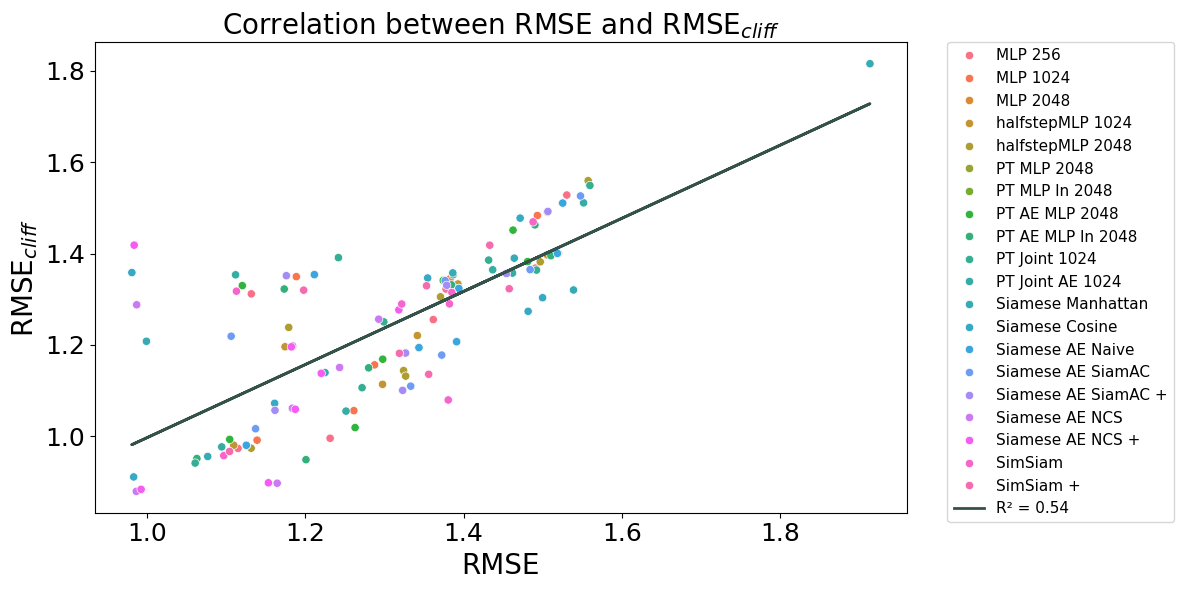

In [31]:
# Combine RMSE and Cliff RMSE data into a single dataframe
rmse_data_mlp = mlp_results_data[mlp_results_data['Metric'] == 'RMSE']
cliff_rmse_data_mlp = mlp_results_data[mlp_results_data['Metric'] == 'Cliff_RMSE']
rmse_data_ac = ac_results_data[ac_results_data['Metric'] == 'RMSE']
cliff_rmse_data_ac = ac_results_data[ac_results_data['Metric'] == 'Cliff_RMSE']

# Combine AC and MLP dataframes
rmse_data = pd.concat([rmse_data_mlp, rmse_data_ac])
cliff_rmse_data = pd.concat([cliff_rmse_data_mlp, cliff_rmse_data_ac])

# Merge dataframes on common columns (e.g., 'Dataset', 'Model')
combined_data = pd.merge(rmse_data, cliff_rmse_data, on=['Dataset', 'Model'], suffixes=('_RMSE', '_Cliff_RMSE'))

# Ensure the correct order of Datasets and Models
combined_data['Dataset'] = pd.Categorical(combined_data['Dataset'], categories=dataset_order, ordered=True)
combined_data['Model'] = pd.Categorical(combined_data['Model'], categories=model_order, ordered=True)

# Extract RMSE and Cliff RMSE values
X = combined_data['Value_RMSE'].values.reshape(-1, 1)
y = combined_data['Value_Cliff_RMSE'].values

# Fit a linear regression model
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Compute R² value
r2 = r2_score(y, y_pred)

# Plot RMSE vs Cliff RMSE
plt.figure(figsize=(12, 6))  # Adjust figure size if necessary
sns.scatterplot(x=combined_data['Value_RMSE'], y=combined_data['Value_Cliff_RMSE'], hue=combined_data['Model'])
plt.plot(combined_data['Value_RMSE'], y_pred, color='#35524A', linewidth=2, label=f'R² = {r2:.2f}')
plt.title('Correlation between RMSE and RMSE$_{cliff}$', fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('RMSE', fontsize=20)
plt.ylabel('RMSE$_{cliff}$', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, borderaxespad=0.)
plt.tight_layout()
plt.show()

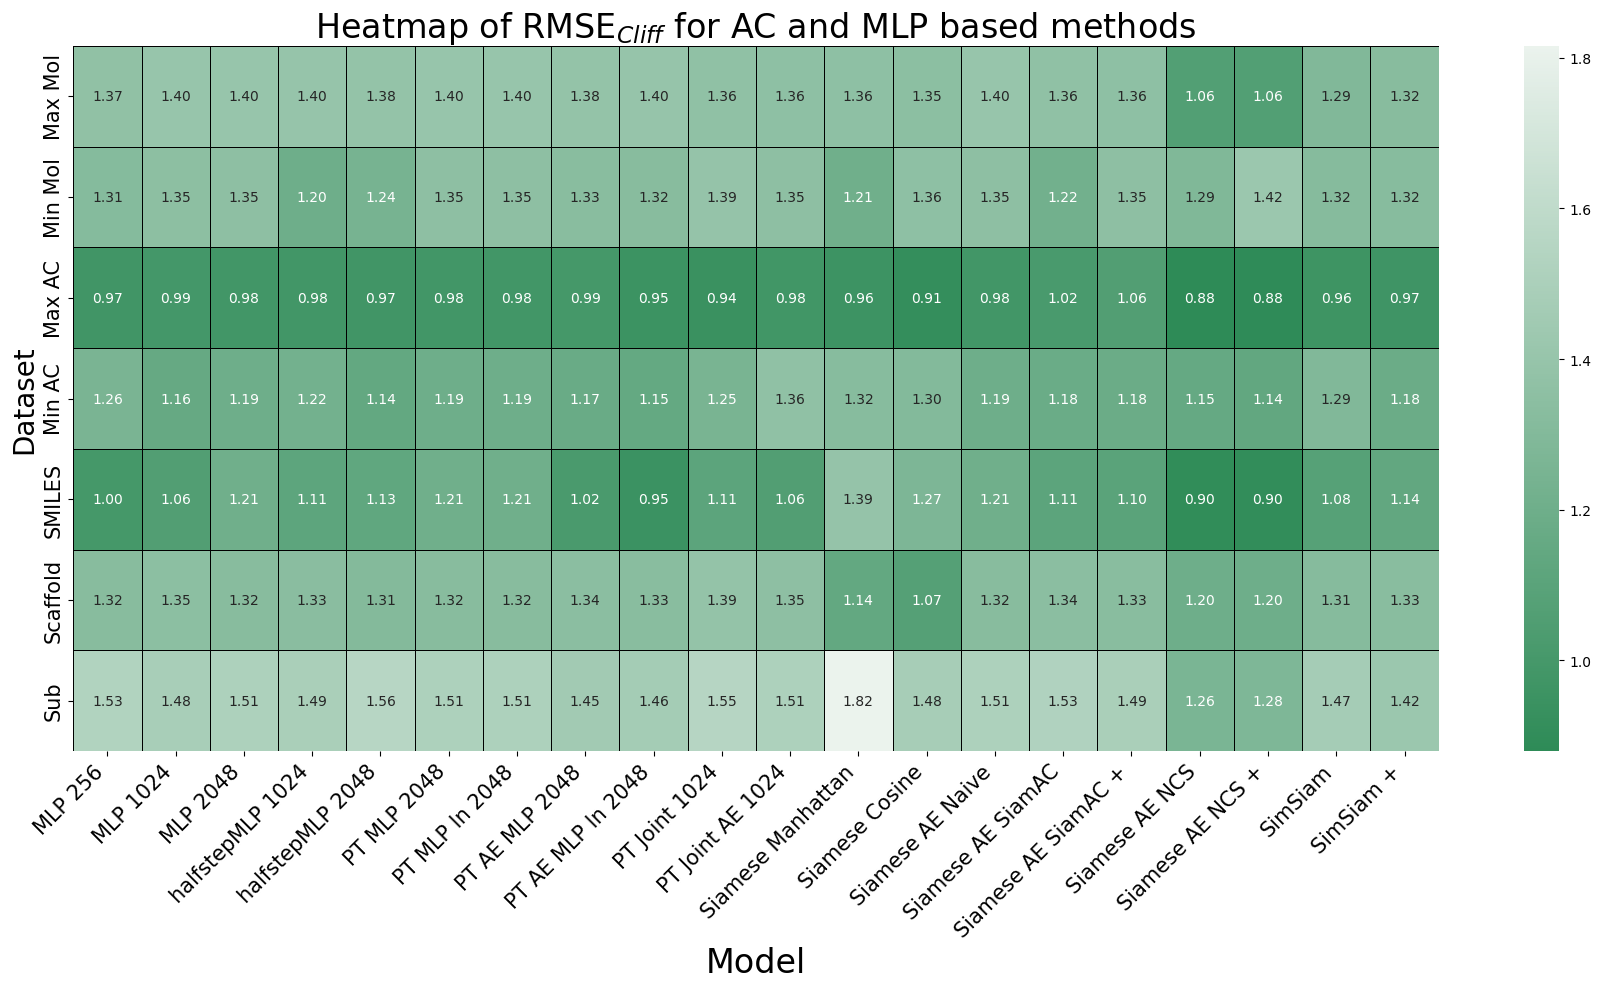

In [34]:
# Filter the data to include only regression tasks and Cliff RMSE metric
ac_data = ac_results_data.loc[(ac_results_data['Task'] == 'regression') & (ac_results_data['Metric'] == 'Cliff_RMSE')].copy()
mlp_data = mlp_results_data.loc[(mlp_results_data['Task'] == 'regression') & (mlp_results_data['Metric'] == 'Cliff_RMSE')].copy()

# Add a new column to distinguish between the two methods
ac_data['Method'] = 'AC based methods'
mlp_data['Method'] = 'MLP based methods'

# Combine into a single DataFrame
combined_data = pd.concat([ac_data, mlp_data])

# Ensure the correct order of Datasets and Models
combined_data['Dataset'] = pd.Categorical(combined_data['Dataset'], categories=dataset_order, ordered=True)
combined_data['Model'] = pd.Categorical(combined_data['Model'], categories=model_order, ordered=True)

# Create the heatmap
plt.figure(figsize=(18, 10))
pivot_table = combined_data.pivot_table(values='Value', index='Dataset', columns='Model')

# Reorder the pivot_table columns based on model_order
pivot_table = pivot_table.reindex(columns=model_order)

# Define the custom color palette using light_palette with seagreen and reverse it
cmap = sns.light_palette("seagreen", reverse=True, as_cmap=True)

sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", linewidths=.5, linecolor='black')

plt.title('Heatmap of RMSE$_{Cliff}$ for AC and MLP based methods', fontsize=24)
plt.xlabel('Model', fontsize=24)
plt.ylabel('Dataset', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

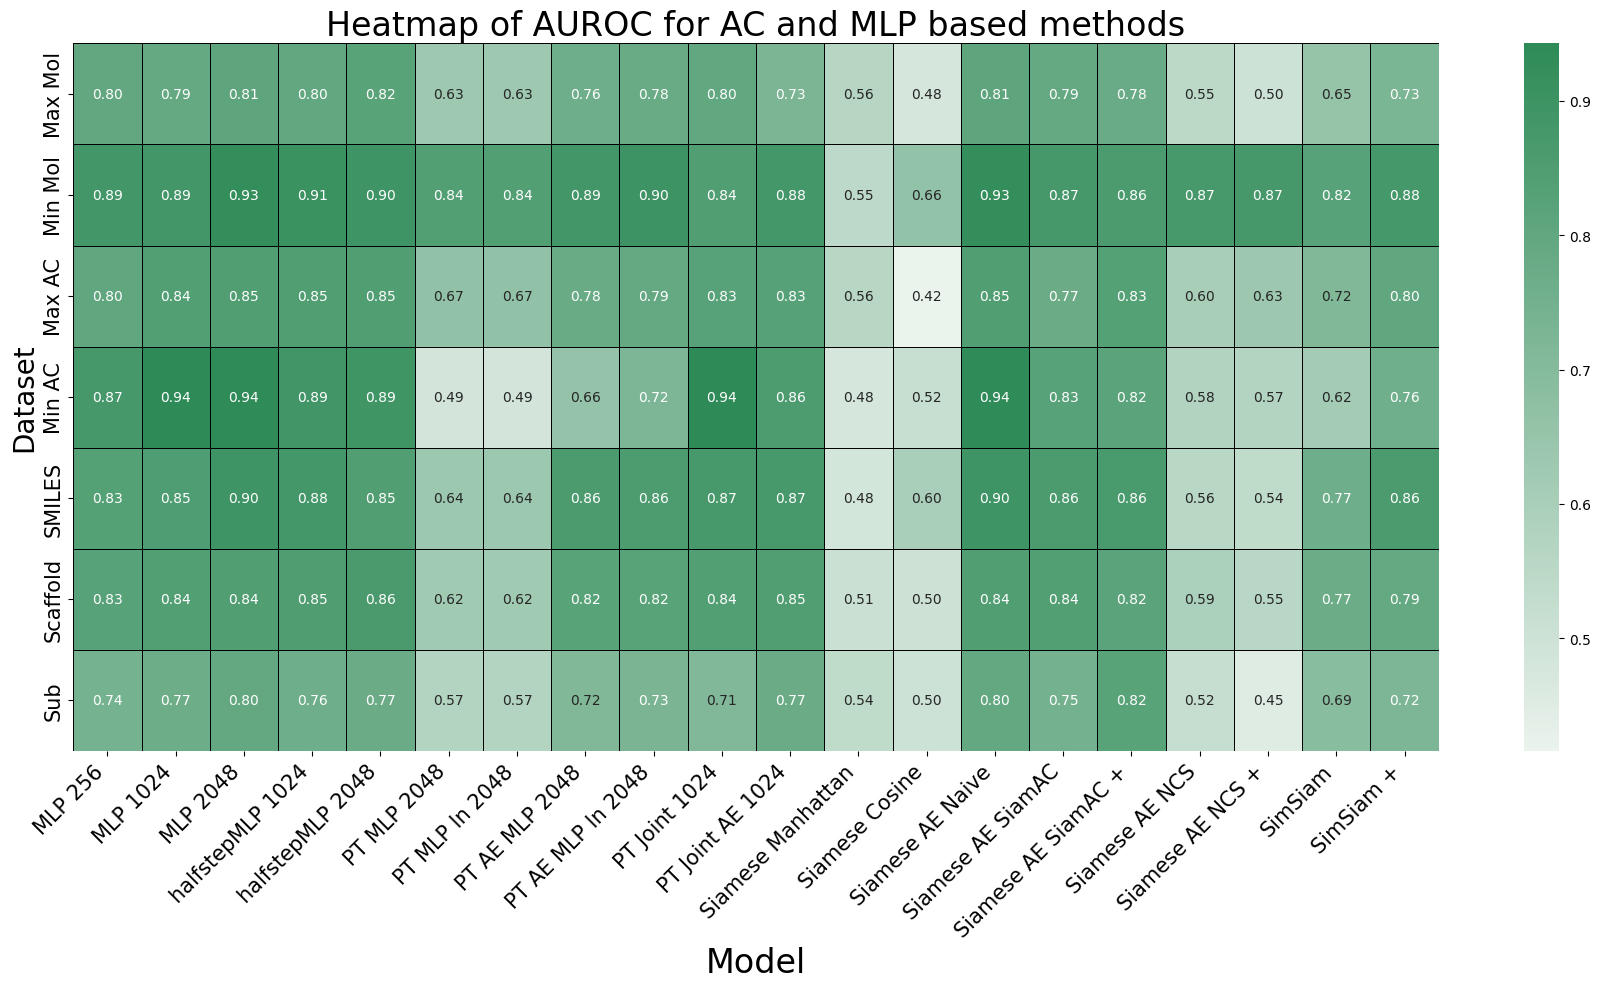

In [37]:
ac_data_auroc = ac_results_data.loc[(ac_results_data['Task'] == 'classification') & (ac_results_data['Metric'] == 'AUROC')].copy()
mlp_data_auroc = mlp_results_data.loc[(mlp_results_data['Task'] == 'classification') & (mlp_results_data['Metric'] == 'AUROC')].copy()

# Add a new column to distinguish between the two methods
ac_data_auroc['Method'] = 'AC based methods'
mlp_data_auroc['Method'] = 'MLP based methods'

# Combine into a single DataFrame
combined_data_auroc = pd.concat([ac_data_auroc, mlp_data_auroc])

# Ensure the correct order of Datasets and Models
combined_data_auroc['Dataset'] = pd.Categorical(combined_data_auroc['Dataset'], categories=dataset_order, ordered=True)
combined_data_auroc['Model'] = pd.Categorical(combined_data_auroc['Model'], categories=model_order, ordered=True)

# Create the heatmap
plt.figure(figsize=(18, 10))
pivot_table_auroc = combined_data_auroc.pivot_table(values='Value', index='Dataset', columns='Model')

# Reorder the pivot_table columns based on model_order
pivot_table_auroc = pivot_table_auroc.reindex(columns=model_order)

# Define the custom color palette using light_palette with seagreen for ascending values
cmap_auroc = sns.light_palette("seagreen", as_cmap=True)

sns.heatmap(pivot_table_auroc, cmap=cmap_auroc, annot=True, fmt=".2f", linewidths=.5, linecolor='black')

plt.title('Heatmap of AUROC for AC and MLP based methods', fontsize=24)
plt.xlabel('Model', fontsize=24)
plt.ylabel('Dataset', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

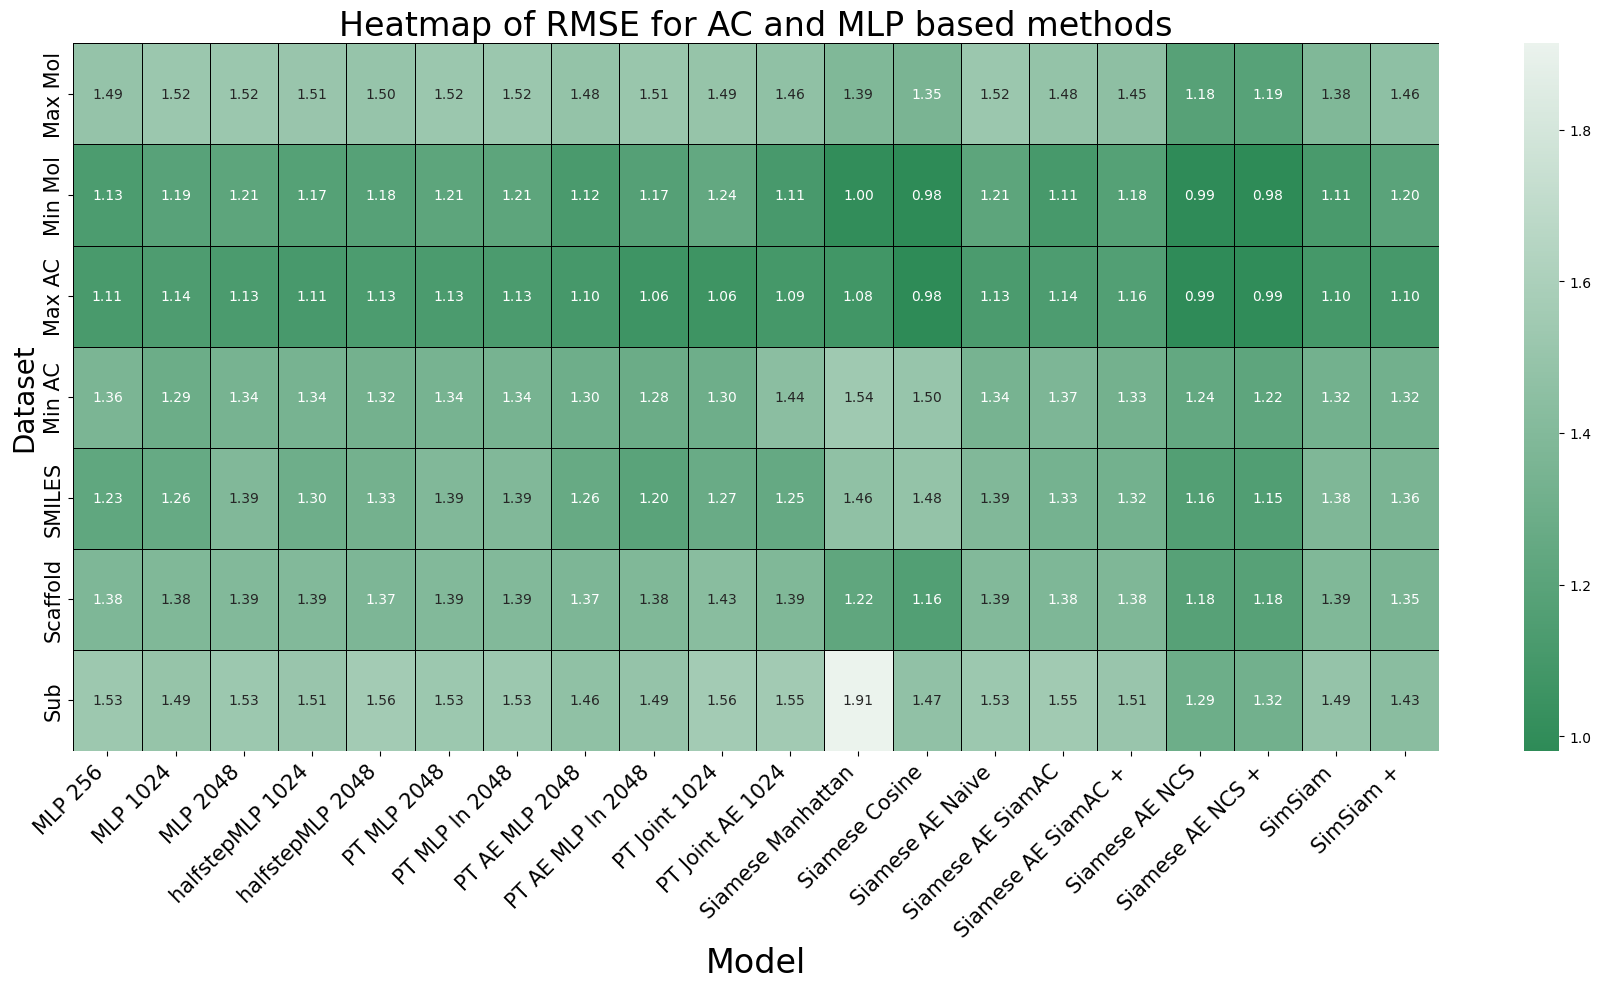

In [38]:
ac_data_rmse = ac_results_data.loc[(ac_results_data['Task'] == 'regression') & (ac_results_data['Metric'] == 'RMSE')].copy()
mlp_data_rmse = mlp_results_data.loc[(mlp_results_data['Task'] == 'regression') & (mlp_results_data['Metric'] == 'RMSE')].copy()

# Add a new column to distinguish between the two methods
ac_data_rmse['Method'] = 'AC based methods'
mlp_data_rmse['Method'] = 'MLP based methods'

# Combine into a single DataFrame
combined_data_rmse = pd.concat([ac_data_rmse, mlp_data_rmse])

# Ensure the correct order of Datasets and Models
combined_data_rmse['Dataset'] = pd.Categorical(combined_data_rmse['Dataset'], categories=dataset_order, ordered=True)
combined_data_rmse['Model'] = pd.Categorical(combined_data_rmse['Model'], categories=model_order, ordered=True)

# Create the heatmap
plt.figure(figsize=(18, 10))
pivot_table_rmse = combined_data_rmse.pivot_table(values='Value', index='Dataset', columns='Model')

# Reorder the pivot_table columns based on model_order
pivot_table_rmse = pivot_table_rmse.reindex(columns=model_order)

# Define the custom color palette using light_palette with seagreen and reverse it for descending values
cmap_rmse = sns.light_palette("seagreen", reverse=True, as_cmap=True)

sns.heatmap(pivot_table_rmse, cmap=cmap_rmse, annot=True, fmt=".2f", linewidths=.5, linecolor='black')

plt.title('Heatmap of RMSE for AC and MLP based methods', fontsize=24)
plt.xlabel('Model', fontsize=24)
plt.ylabel('Dataset', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

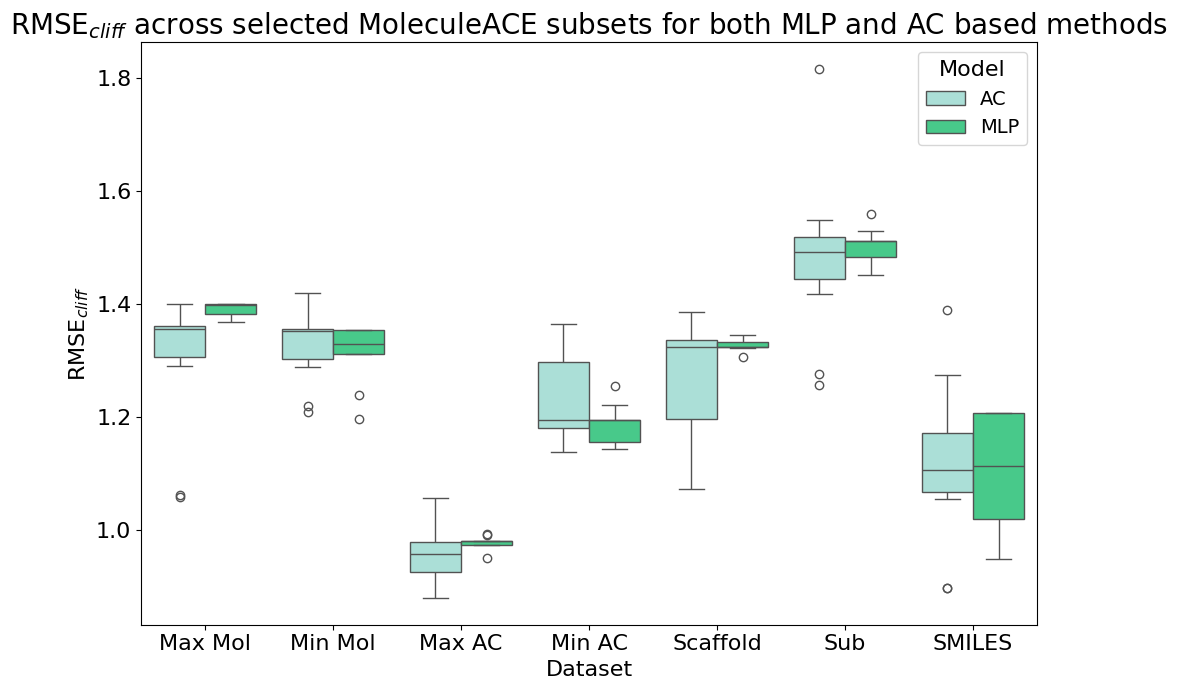

In [20]:
# Filter the data to include only regression tasks and Cliff RMSE metric
ac_data = ac_results_data.loc[(ac_results_data['Task'] == 'regression') & (ac_results_data['Metric'] == 'Cliff_RMSE')].copy()
mlp_data = mlp_results_data.loc[(mlp_results_data['Task'] == 'regression') & (mlp_results_data['Metric'] == 'Cliff_RMSE')].copy()

# Add a new column to distinguish between the two methods
ac_data['Model_Type'] = 'AC'
mlp_data['Model_Type'] = 'MLP'

# Combine into a single DataFrame
combined_data = pd.concat([ac_data, mlp_data])

# Box plot for 'Cliff_RMSE'
desired_order = ['Max Mol', 'Min Mol', 'Max AC', 'Min AC', 'Scaffold', 'Sub', 'SMILES']
combined_data['Dataset'] = pd.Categorical(combined_data['Dataset'], categories=desired_order, ordered=True)

colors = ['#A2E8DD', '#32DE8A']

plt.figure(figsize=(10, 7))
sns.boxplot(x='Dataset', y='Value', hue='Model_Type', data=combined_data, palette=colors)
plt.title('RMSE$_{cliff}$ across selected MoleculeACE subsets for both MLP and AC based methods',
          fontsize=20)

plt.ylabel('RMSE$_{cliff}$', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
plt.legend(title='Model', fontsize=14, title_fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

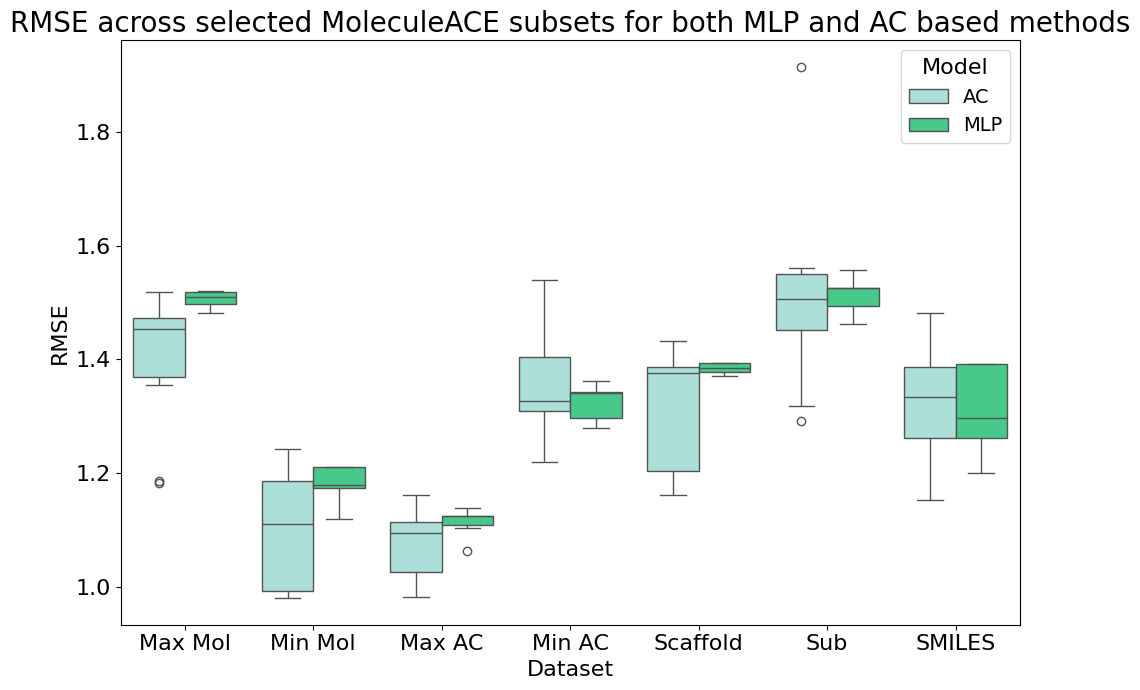

In [22]:
# Filter the data to include only regression tasks and RMSE metric
ac_data = ac_results_data.loc[(ac_results_data['Task'] == 'regression') & (ac_results_data['Metric'] == 'RMSE')].copy()
mlp_data = mlp_results_data.loc[(mlp_results_data['Task'] == 'regression') & (mlp_results_data['Metric'] == 'RMSE')].copy()

# Add a new column to distinguish between the two methods
ac_data['Model_Type'] = 'AC'
mlp_data['Model_Type'] = 'MLP'

# Combine into a single DataFrame
combined_data = pd.concat([ac_data, mlp_data])

# Box plot for RMSE
desired_order = ['Max Mol', 'Min Mol', 'Max AC', 'Min AC', 'Scaffold', 'Sub', 'SMILES']
combined_data['Dataset'] = pd.Categorical(combined_data['Dataset'], categories=desired_order, ordered=True)

colors = ['#A2E8DD', '#32DE8A']

plt.figure(figsize=(10, 7))
sns.boxplot(x='Dataset', y='Value', hue='Model_Type', data=combined_data, palette=colors)
plt.title('RMSE across selected MoleculeACE subsets for both MLP and AC based methods', fontsize=20)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Model', fontsize=14, title_fontsize=16)
plt.tight_layout()
plt.show()

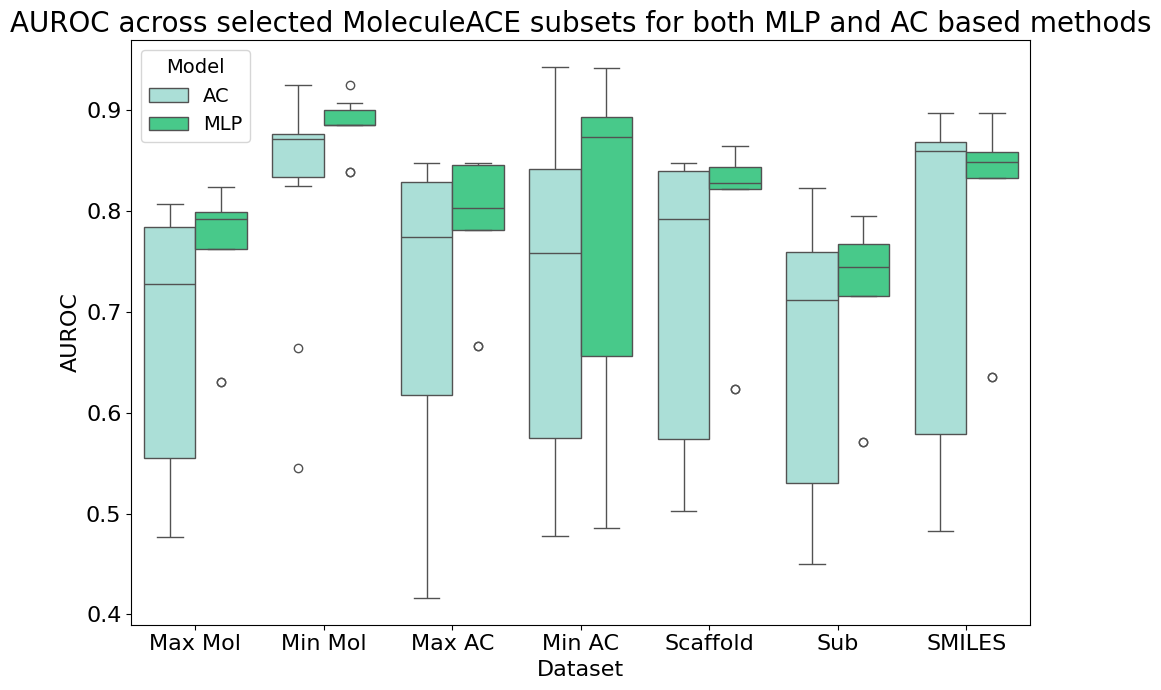

In [23]:
# Filter the data to include only classification tasks and AUROC metric
ac_data = ac_results_data.loc[(ac_results_data['Task'] == 'classification') & (ac_results_data['Metric'] == 'AUROC')].copy()
mlp_data = mlp_results_data.loc[(mlp_results_data['Task'] == 'classification') & (mlp_results_data['Metric'] == 'AUROC')].copy()

# Add a new column to distinguish between the two methods
ac_data['Model_Type'] = 'AC'
mlp_data['Model_Type'] = 'MLP'

# Combine into a single DataFrame
combined_data = pd.concat([ac_data, mlp_data])

# Box plot for AUROC
desired_order = ['Max Mol', 'Min Mol', 'Max AC', 'Min AC', 'Scaffold', 'Sub', 'SMILES']
combined_data['Dataset'] = pd.Categorical(combined_data['Dataset'], categories=desired_order, ordered=True)

colors = ['#A2E8DD', '#32DE8A']

plt.figure(figsize=(10, 7))
sns.boxplot(x='Dataset', y='Value', hue='Model_Type', data=combined_data, palette=colors)
plt.title('AUROC across selected MoleculeACE subsets for both MLP and AC based methods', fontsize=20)
plt.ylabel('AUROC', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', title='Model', fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.show()

## bars

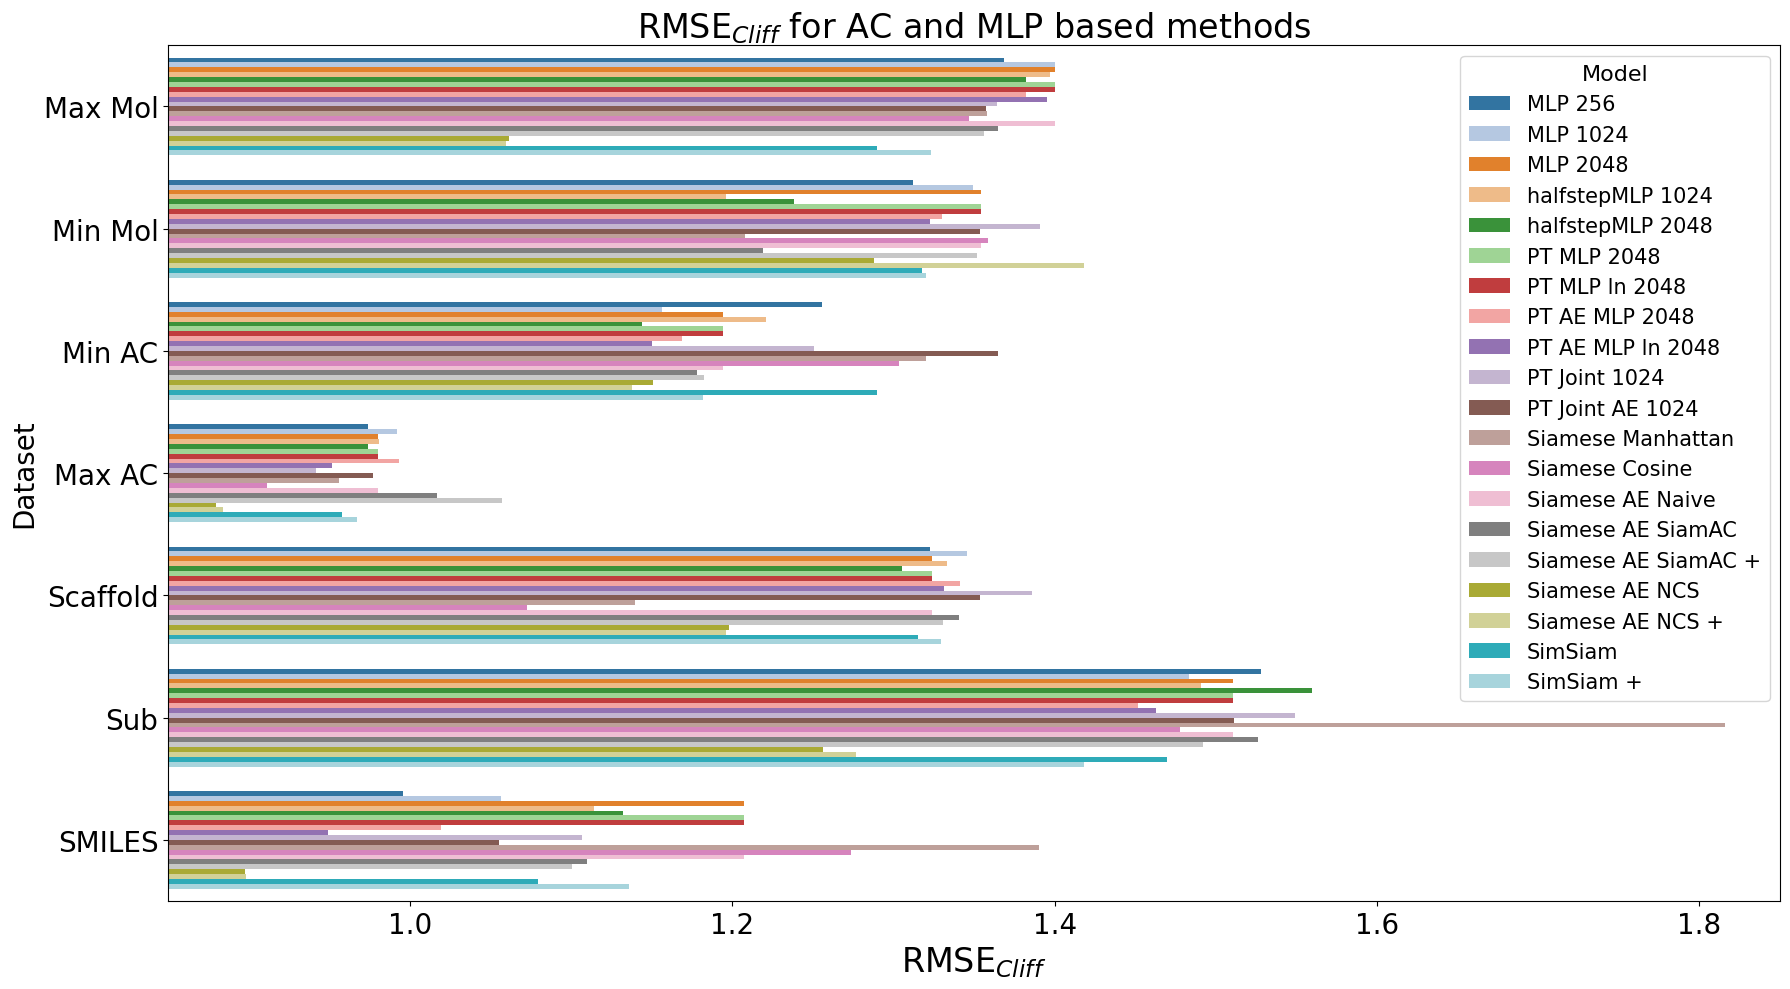

In [10]:
# Define the desired order of models
desired_order_models = [
    'MLP 256', 'MLP 1024', 'MLP 2048', 'halfstepMLP 1024', 'halfstepMLP 2048',
    'PT MLP 2048', 'PT MLP ln 2048', 'PT AE MLP 2048', 'PT AE MLP ln 2048',
    'PT Joint 1024', 'PT Joint AE 1024', 'Siamese Manhattan', 'Siamese Cosine',
    'Siamese AE Naive', 'Siamese AE SiamAC', 'Siamese AE SiamAC +',
    'Siamese AE NCS', 'Siamese AE NCS +', 'SimSiam', 'SimSiam +'
]

# Define the color palette
palette = sns.color_palette("tab20", len(desired_order_models))

# 1. Plot for Cliff RMSE

# Filter the data to include only regression tasks and Cliff RMSE metric
ac_data = ac_results_data.loc[(ac_results_data['Task'] == 'regression') & (ac_results_data['Metric'] == 'Cliff_RMSE')].copy()
mlp_data = mlp_results_data.loc[(mlp_results_data['Task'] == 'regression') & (mlp_results_data['Metric'] == 'Cliff_RMSE')].copy()

# Add a new column to distinguish between the two methods
ac_data['Method'] = 'AC based methods'
mlp_data['Method'] = 'MLP based methods'

# Combine into a single DataFrame
combined_data = pd.concat([ac_data, mlp_data])

# Create the plot
plt.figure(figsize=(18, 10))
sns.barplot(x='Value', y='Dataset', hue='Model', data=combined_data, palette=palette, hue_order=desired_order_models, errorbar=None)
plt.title('RMSE$_{Cliff}$ for AC and MLP based methods', fontsize=24)
plt.legend(title='Model', fontsize=15, title_fontsize=16)
plt.xlabel('RMSE$_{Cliff}$', fontsize=24)
plt.xlim(0.85, 1.85)
plt.ylabel('Dataset', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title='Model', loc='upper right', fontsize=15, title_fontsize=16)
plt.tight_layout()
plt.show()

## Refs

[1] Derek van Tilborg, Alisa Alenicheva, and Francesca Grisoni.“Exposing the Limitations of Molecular Machine Learning with Activity Cliffs”. In: Journal of Chemical Information and Modeling 62.23 (Dec. 2022), pp. 5938–5951. DOI: 10.1021/acs.jcim.2c01073. URL: https://doi.
org/10.1021/acs.jcim.2c01073.   
[2] César Miguel Valdez Córdova. Towards learning activity cliff-aware molecular representations. Publication pending.